Setup: Imports & Data Generation

In [1]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

# Data generation utilities
from easy_boston_data import (
    generate_correlated_boston_like_data,
    generate_easy_boston_like_data
)

# Core solvers
from iterative_solvers import ista, fista, fista_delta
from lbfgs import LBFGSSolver

Preprocessing & Regularization Settings

In [2]:
# 3.1.1 Generate correlated data & standardize
A, b, x_true = generate_correlated_boston_like_data(m=800, seed=42, noise_std=0.1)
A = (A - A.mean(axis=0)) / A.std(axis=0)
b = b - b.mean()

# 3.1.2 Define regularization scenarios
basic_regs = [
    {'name':'lasso',      'alpha1':1.0,   'alpha2':0.0},
    {'name':'elasticnet', 'alpha1':1.0,   'alpha2':1.0},
    {'name':'lasso',      'alpha1':0.5,   'alpha2':0.0},
    {'name':'elasticnet', 'alpha1':0.2,   'alpha2':0.05},
    {'name':'elasticnet', 'alpha1':1e-4,  'alpha2':0.5}
]

Baseline: Vanilla ISTA vs FISTA

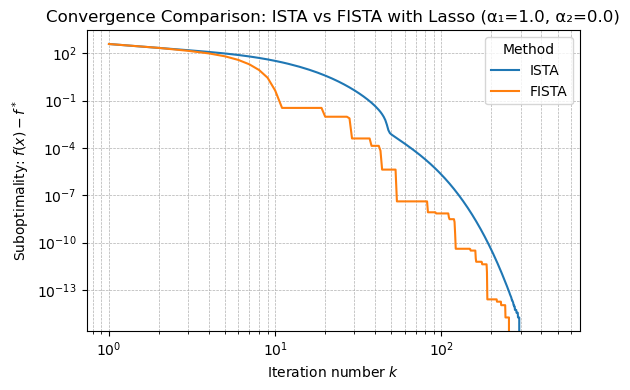

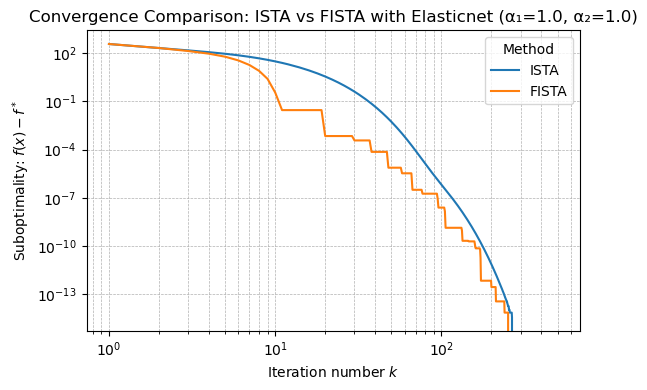

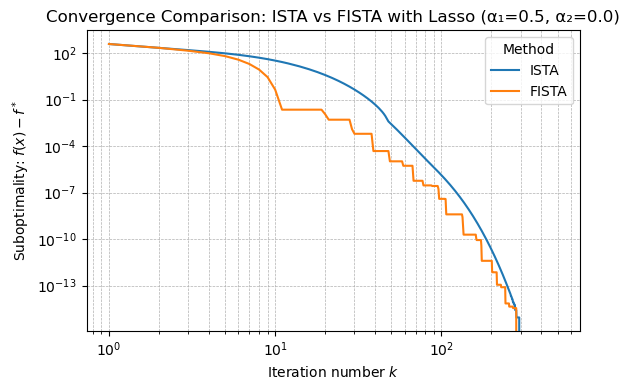

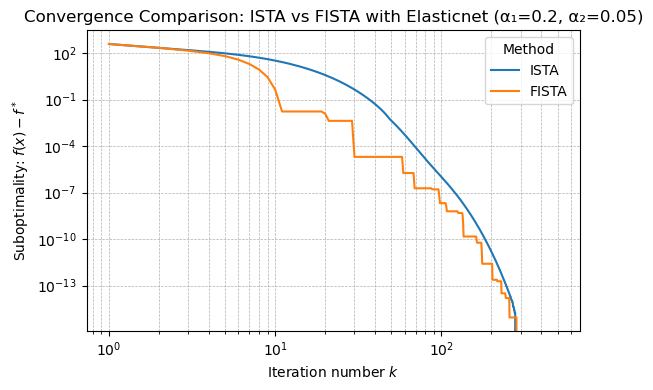

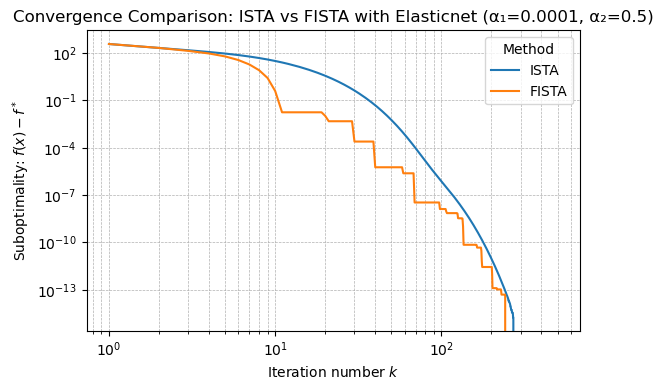

In [3]:
records = []
for reg in basic_regs:
    name, a1, a2 = reg['name'], reg['alpha1'], reg['alpha2']

    # --- Run ISTA ---
    t0 = time.perf_counter()
    x_i, obj_i = ista(A, b, name, a1, a2)
    t_i = time.perf_counter() - t0

    # --- Run FISTA ---
    t0 = time.perf_counter()
    x_f, obj_f = fista(A, b, name, a1, a2)
    t_f = time.perf_counter() - t0

    # Estimate optimal value f*
    f_star = obj_f[-1]

    # Plot suboptimality curves for both methods
    ks = np.arange(1, len(obj_i) + 1)
    plt.figure(figsize=(6,4))
    plt.loglog(ks, np.minimum.accumulate(np.array(obj_i) - f_star), '-', label='ISTA')
    plt.loglog(ks, np.minimum.accumulate(np.array(obj_f) - f_star), '-', label='FISTA')
    plt.title(f"Convergence Comparison: ISTA vs FISTA with {name.title()} (α₁={a1}, α₂={a2})")
    plt.xlabel('Iteration number $k$')
    plt.ylabel('Suboptimality: $f(x) - f^*$')
    plt.grid(True, which='both', ls='--', lw=0.5)
    plt.legend(title='Method')
    plt.tight_layout()
    plt.show()

    # Record summary statistics
    records += [
        {'method':'ISTA',  'regularizer':name, 'alpha1':a1, 'alpha2':a2,
         'iterations':len(obj_i),  'runtime_s':t_i},
        {'method':'FISTA', 'regularizer':name, 'alpha1':a1, 'alpha2':a2,
         'iterations':len(obj_f), 'runtime_s':t_f}
    ]

# Aggregate results into DataFrame

Advanced: ISTA Stopping & FISTA Adaptive-Restart

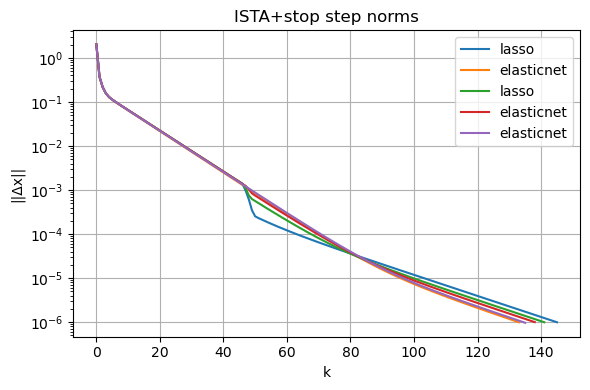

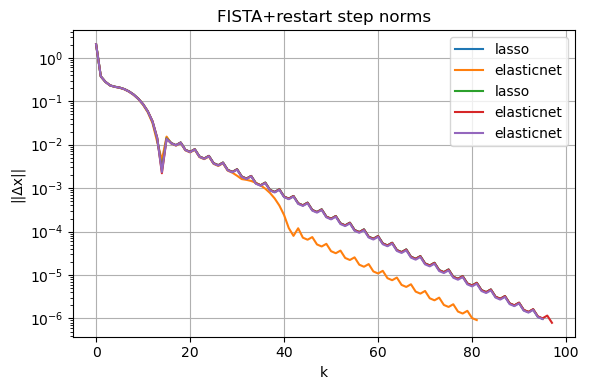

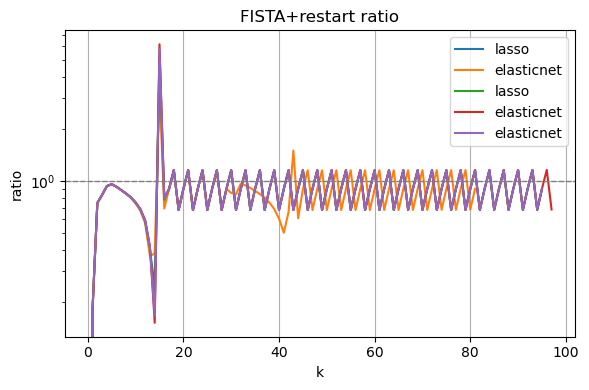

In [4]:
# Re-run with stopping and restart criteria
advanced = []
tol = 1e-6

for reg in basic_regs:
    name, a1, a2 = reg['name'], reg['alpha1'], reg['alpha2']
    if name == 'ridge':
        continue

    # ISTA with tol stopping (using return_history version)
    x_i2, obj_i2, step_i2, xhist_i2 = ista(
        A, b, name, a1, a2, max_iter=500, tol=tol, return_history=True
    )

    # FISTA with adaptive restart (return_history)
    x_f2, obj_f2, step_f2, ratio_f2, xhist_f2 = fista(
        A, b, name, a1, a2,
        max_iter=500, tol=tol,
        adaptive_restart=True, restart_threshold=1.0,
        return_history=True
    )

    advanced += [
        {'method':'ISTA+stop',    'regularizer':name, 'step_norms':step_i2, 'x_hist':xhist_i2},
        {'method':'FISTA+restart', 'regularizer':name, 'step_norms':step_f2, 'ratio_vals':ratio_f2, 'x_hist':xhist_f2}
    ]

# Plot step-norms
plt.figure(figsize=(6,4))
for run in advanced:
    if run['method']=='ISTA+stop':
        plt.semilogy(run['step_norms'], label=run['regularizer'])
plt.title('ISTA+stop step norms')
plt.xlabel('k'); plt.ylabel('||Δx||'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
for run in advanced:
    if run['method']=='FISTA+restart':
        plt.semilogy(run['step_norms'], label=run['regularizer'])
plt.title('FISTA+restart step norms')
plt.xlabel('k'); plt.ylabel('||Δx||'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

# Plot ratios
plt.figure(figsize=(6,4))
for run in advanced:
    if run['method']=='FISTA+restart':
        plt.semilogy(run['ratio_vals'], label=run['regularizer'])
plt.axhline(1.0, ls='--', lw=1, color='gray')
plt.title('FISTA+restart ratio'); plt.xlabel('k'); plt.ylabel('ratio'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

Ridge Regression via L-BFGS

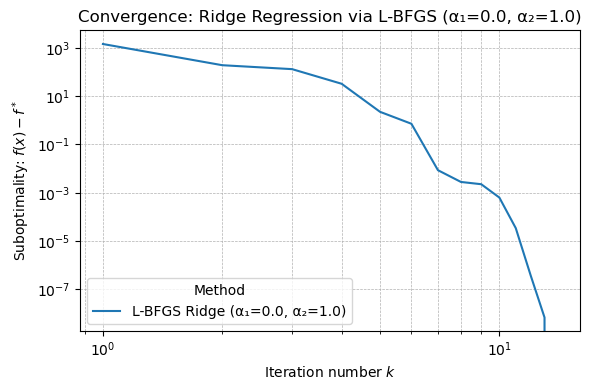

In [5]:
# Configure and run L-BFGS solver for Ridge
ridge_solver = LBFGSSolver(reg_type='ridge', alpha1=0.0, alpha2=1.0, max_iter=500, tol=1e-6)
# Measure runtime
tr0 = time.perf_counter()
ridge_solver.fit(A, b)
tridge = time.perf_counter() - tr0

# Plot convergence envelope of L-BFGS for Ridge
ks_r = np.arange(1, len(ridge_solver.history_) + 1)
plt.figure(figsize=(6,4))
plt.loglog(
    ks_r,
    np.minimum.accumulate(np.array(ridge_solver.history_) - ridge_solver.final_obj_),
    '-', label=f"L-BFGS Ridge (α₁=0.0, α₂=1.0)"
)
plt.title("Convergence: Ridge Regression via L-BFGS (α₁=0.0, α₂=1.0)")
plt.xlabel('Iteration number $k$')
plt.ylabel('Suboptimality: $f(x) - f^*$')
plt.grid(True, which='both', ls='--', lw=0.5)
plt.legend(title='Method')
plt.tight_layout()
plt.show()

# Append summary to records
ridge_summary = {
    'method': 'L-BFGS',
    'regularizer': 'ridge',
    'alpha1': 0.0,
    'alpha2': 1.0,
    'iterations': len(ridge_solver.history_),
    'runtime_s': tridge
}

FISTA vs FISTA-Delta Comparison

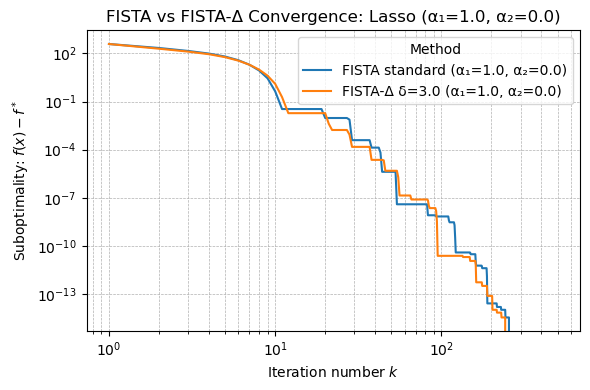

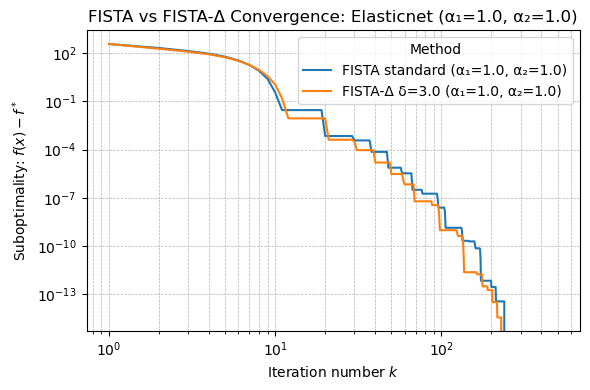

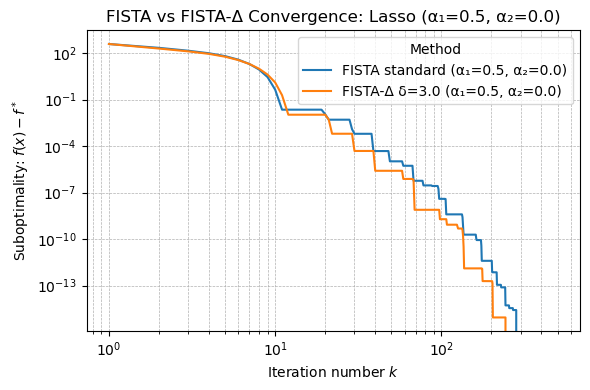

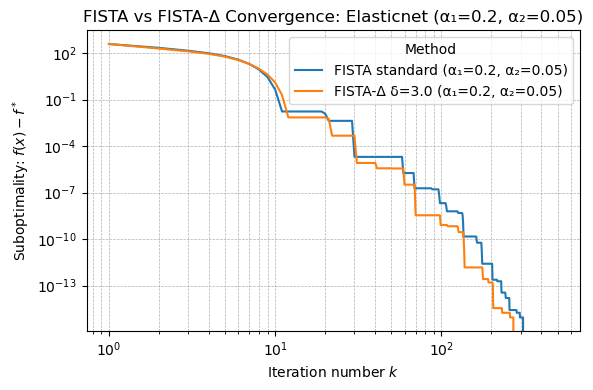

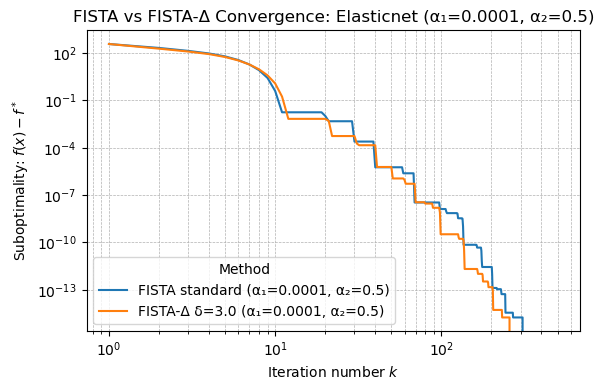

In [6]:
# Compare standard FISTA and FISTA-Delta for Lasso and ElasticNet cases
variants = []
delta = 3.0
for reg in basic_regs:
    name, a1, a2 = reg['name'], reg['alpha1'], reg['alpha2']
    if name not in ('lasso','elasticnet') or a1 <= 0.0:
        continue
    # Standard FISTA
    t0 = time.perf_counter()
    x_std, obj_std = fista(A, b, name, a1, a2, max_iter=500)
    t_std = time.perf_counter() - t0
    # FISTA-Delta
    t0 = time.perf_counter()
    x_del, obj_del = fista_delta(A, b, name, a1, a2, delta=delta, max_iter=500)
    t_del = time.perf_counter() - t0
    # Estimate best f*
    f_star = min(obj_std[-1], obj_del[-1])
    # Plot convergence envelopes
    ks_std = np.arange(1, len(obj_std)+1)
    ks_del = np.arange(1, len(obj_del)+1)
    env_std = np.minimum.accumulate(np.array(obj_std) - f_star)
    env_del = np.minimum.accumulate(np.array(obj_del) - f_star)
    plt.figure(figsize=(6,4))
    plt.loglog(ks_std, env_std, '-', label=f"FISTA standard (α₁={a1}, α₂={a2})")
    plt.loglog(ks_del, env_del, '-', label=f"FISTA-Δ δ={delta} (α₁={a1}, α₂={a2})")
    plt.title(f"FISTA vs FISTA-Δ Convergence: {name.title()} (α₁={a1}, α₂={a2})")
    plt.xlabel('Iteration number $k$')
    plt.ylabel('Suboptimality: $f(x) - f^*$')
    plt.grid(True, which='both', ls='--', lw=0.5)
    plt.legend(title='Method')
    plt.tight_layout()
    plt.show()
    # Record summary
    variants += [
        {'method':'FISTA','delta':None,'regularizer':name,'alpha1':a1,'alpha2':a2,'iterations':len(obj_std),'runtime_s':t_std},
        {'method':'FISTA-DELTA','delta':delta,'regularizer':name,'alpha1':a1,'alpha2':a2,'iterations':len(obj_del),'runtime_s':t_del}
    ]
# Aggregate variant results into DataFrame